In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Modeling pre-processing with non-scikit-learn packages
from category_encoders.ordinal import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [122]:
housing = pd.read_csv("../data/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Dummy Encoding

In [123]:
# dummy encode
encoder = OneHotEncoder(drop='first')

# apply to all categorical features
dummy_encoder = ColumnTransformer([("dummy", encoder, selector(dtype_include="object"))])

### Filter out zero or near-zero variance features.

In [124]:
housing.var()

/tmp/ipykernel_1582/2527284353.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  housing.var()


longitude             4.014139e+00
latitude              4.562293e+00
housing_median_age    1.583963e+02
total_rooms           4.759445e+06
total_bedrooms        1.775654e+05
population            1.282470e+06
households            1.461760e+05
median_income         3.609323e+00
median_house_value    1.331615e+10
dtype: float64

In [125]:
nzv = VarianceThreshold(threshold=0.1)

### Imputation

In [126]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [127]:
housing.drop(['longitude', 'latitude'], axis=1 , inplace=True)

In [128]:
knn_imp = KNNImputer(n_neighbors=6)

In [129]:
bedrooms_mean = float(int(housing["total_bedrooms"].mean()))
housing["total_bedrooms"].fillna(bedrooms_mean, inplace = True)

In [130]:
housing.isnull().sum()

housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [131]:
def map_age(age):
    if age == '<1H OCEAN':
        return 0
    elif age == 'INLAND':
        return 1
    elif age == 'NEAR OCEAN':
        return 2
    elif age == 'NEAR BAY':
        return 3
    elif age == 'ISLAND':
        return 4
housing['ocean_proximity'] = housing['ocean_proximity'].apply(map_age)

In [132]:
# create train/test split
train, test = train_test_split(housing, train_size=0.7, random_state=123)

In [133]:
# separate features from labels and only use numeric features
X_train = train.drop("median_house_value", axis=1)
y_train = train[["median_house_value"]]

In [134]:
housing["ocean_proximity"].value_counts()

0    9136
1    6551
2    2658
3    2290
4       5
Name: ocean_proximity, dtype: int64

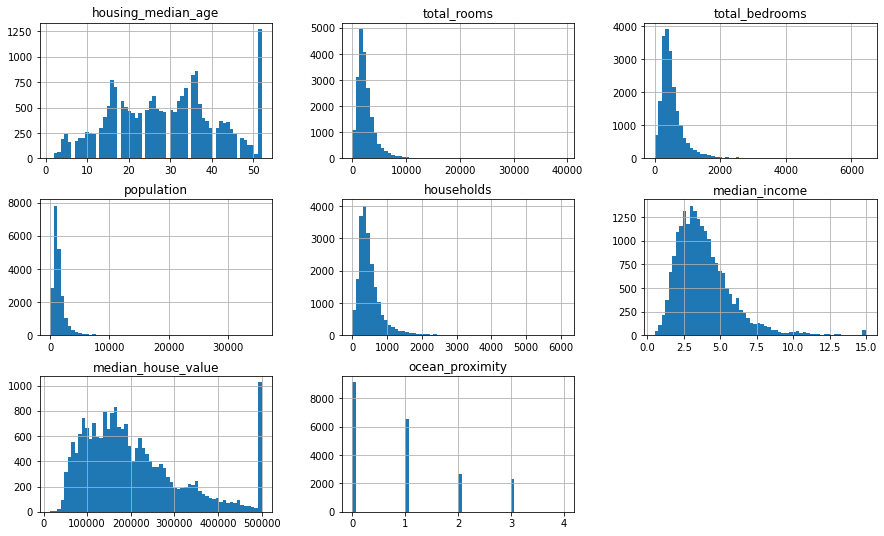

In [135]:
housing.hist(bins=60, figsize=(15,9));plt.show()

###  solving Skewness using yeo-johnson

In [136]:
X_norm = ColumnTransformer([("norm",  PowerTransformer(method = "yeo-johnson"), selector(dtype_include="number"))])

### Standardization

In [137]:
scaler = StandardScaler()

# standardize all numeric features
std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

In [138]:
pca = PCA(n_components=30)


In [139]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),

  ("std_encode", scaler, selector(dtype_include="number")),
 
  ("dummy", dummy_encoder, selector(dtype_include="object")),
  ])

In [140]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('nzv_encode', VarianceThreshold(threshold=0.1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf58110a0>),
                                ('std_encode', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf3cfb460>),
                                ('dummy',
                                 ColumnTransformer(transformers=[('dummy',
                                                                  OneHotEncoder(drop='first'),
                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf4130700>)]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf5bac970>)])

In [141]:
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
#   ("knn", knn),
])

In [142]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nzv_encode',
                                                  VarianceThreshold(threshold=0.1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf58110a0>),
                                                 ('std_encode',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf3cfb460>),
                                                 ('dummy',
                                                  ColumnTransformer(transformers=[('dummy',
                                                                                   OneHotEncoder(drop='first'),
                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf4130700>)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efbf5bac970>)]))])

In [143]:

X_train_scaled = scaler.fit_transform(X_train)


In [144]:
ridge_mod = Ridge(alpha=1)


In [145]:
ridge_fit = ridge_mod.fit(X_train_scaled, y_train)


In [146]:
ridge_fit.coef_

array([[ 23111.32803176, -37197.90030022,  28520.53839902,
        -43917.34101834,  59732.60510687,  89496.42047292,
           224.27009471]])